### Project Summary: 1. We work on a dataset of 255k Customers and develop a default prediction model.                

### 2. The dataset has only 11 % defaulters and thus exhibits a huge imbalance, as shown through the Random Forest Model.

### 3. We use XGBoost, which can deal with this imbalance better. We then compute the Recall-Precision Curve and choose a threshold for the default probability based on it, with the goal of balancing Recall and Precision

In [8]:
import pandas as pd
data_descriptions = pd.read_csv('data_descriptions.csv')
pd.set_option('display.max_colwidth', None)
data_descriptions

,Column_name,Column_type,Data_type,Description
0,LoanID,Identifier,string,A unique identifier for each loan.
1,Age,Feature,integer,The age of the borrower.
2,Income,Feature,integer,The annual income of the borrower.
3,LoanAmount,Feature,integer,The amount of money being borrowed.
4,CreditScore,Feature,integer,"The credit score of the borrower, indicating their creditworthiness."
5,MonthsEmployed,Feature,integer,The number of months the borrower has been employed.
6,NumCreditLines,Feature,integer,The number of credit lines the borrower has open.
7,InterestRate,Feature,float,The interest rate for the loan.
8,LoanTerm,Feature,integer,The term length of the loan in months.
9,DTIRatio,Feature,float,"The Debt-to-Income ratio, indicating the borrower's debt compared to their income."


In [9]:
# Import required packages

# Data packages
import pandas as pd
import numpy as np

# Machine Learning / Classification packages
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

# Visualization Packages
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

## Load the Data

Let's start by loading the dataset `train.csv` into a dataframe `train_df`, and `test.csv` into a dataframe `test_df` and display the shape of the dataframes.

In [10]:
train_df = pd.read_csv("train.csv")
print('train_df Shape:', train_df.shape)
train_df.head()

train_df Shape: (255347, 18)


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

<Axes: xlabel='Default', ylabel='Age'>

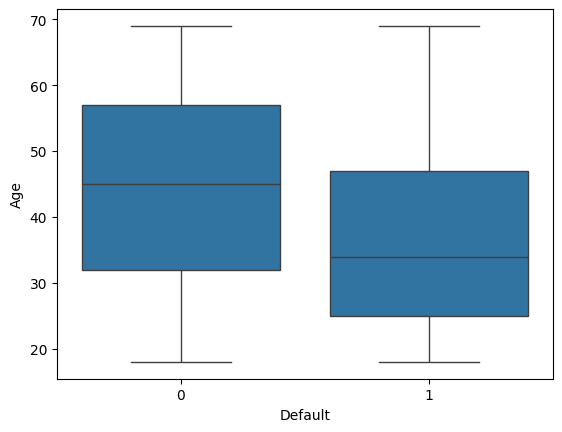

In [12]:
sns.boxplot(x='Default', y='Age', data=train_df)

### Median age of defaulters is much higher

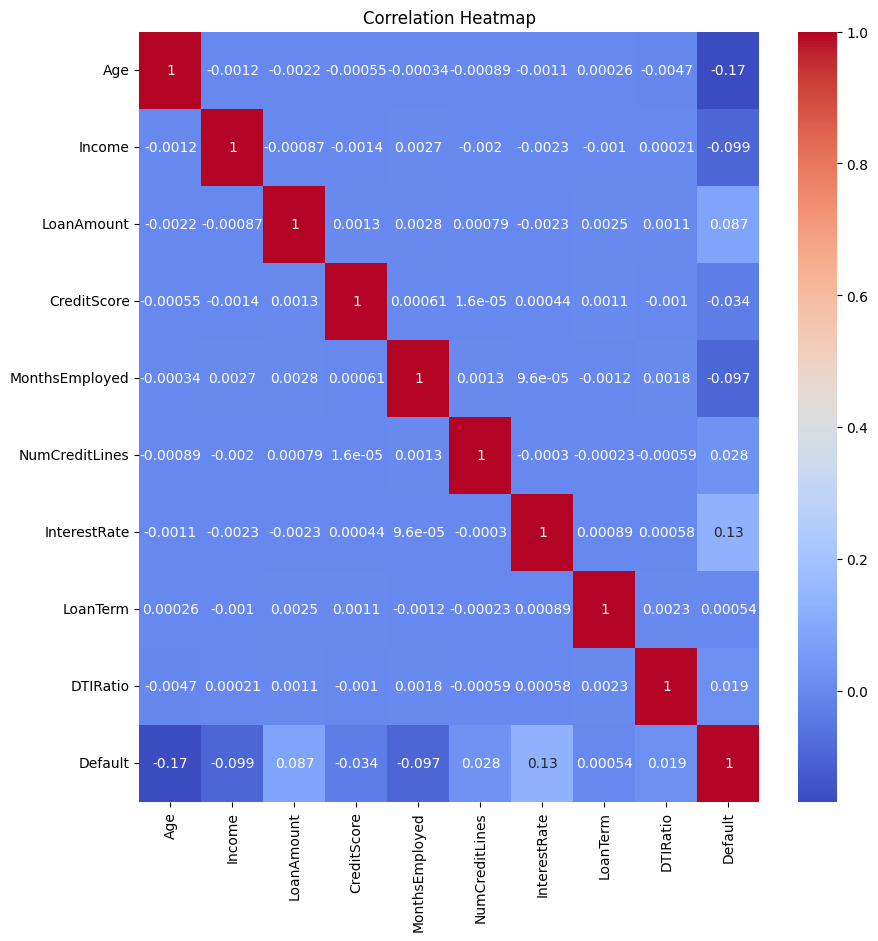

In [13]:
num_columns=train_df.select_dtypes(exclude='object')
plt.figure(figsize=(10,10))
sns.heatmap(num_columns.corr(), annot=True, cmap='coolwarm')

plt.title('Correlation Heatmap')
plt.show()

### No strong correlations to worry about

## First we try Random Forests

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
X = train_df.drop(columns=["LoanID", "Default"])
y = train_df["Default"]

# Encode categorical variables using LabelEncoder
categorical_cols = X.select_dtypes(include="object").columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    train_df[col] = le.transform(train_df[col])
    label_encoders[col] = le



# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on validation set
y_pred = clf.predict(X_val)

# Evaluation
#report = classification_report(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)


# Convert it to a DataFrame for clean display


#report, conf_matrix

In [ ]:
report_dict = classification_report(y_val, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Round the values for readability
report_df = report_df.round(3)

# Display the DataFrame
report_df

,precision,recall,f1-score,support
0,0.889,0.996,0.940,45170.000
1,0.625,0.048,0.089,5900.000
accuracy,0.887,0.887,0.887,0.887
macro avg,0.757,0.522,0.514,51070.000
weighted avg,0.858,0.887,0.841,51070.000


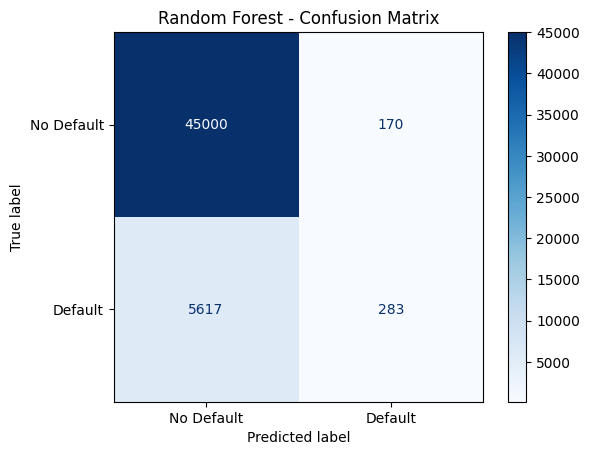

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_val, y_pred)

# Display as heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Default", "Default"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Random Forest - Confusion Matrix")
plt.show()

## We have too many false negatives! That is, recall late is really low. About 5000 people predicted to be safe actually defaulted - this is very risky. Lets tune our Random Forest model to focus more on defaulters

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # Tells the model to focus more on minority class
    random_state=42
)
rf_model.fit(X_train, y_train)

# Predict on validation set
y_pred_2 = rf_model.predict(X_val)

# Evaluation
#report = classification_report(y_val, y_pred)
conf_matrix_2 = confusion_matrix(y_val, y_pred_2)
report_dict = classification_report(y_val, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Round the values for readability
report_df = report_df.round(3)


In [ ]:
report_df

,precision,recall,f1-score,support
0,0.889,0.996,0.940,45170.000
1,0.625,0.048,0.089,5900.000
accuracy,0.887,0.887,0.887,0.887
macro avg,0.757,0.522,0.514,51070.000
weighted avg,0.858,0.887,0.841,51070.000


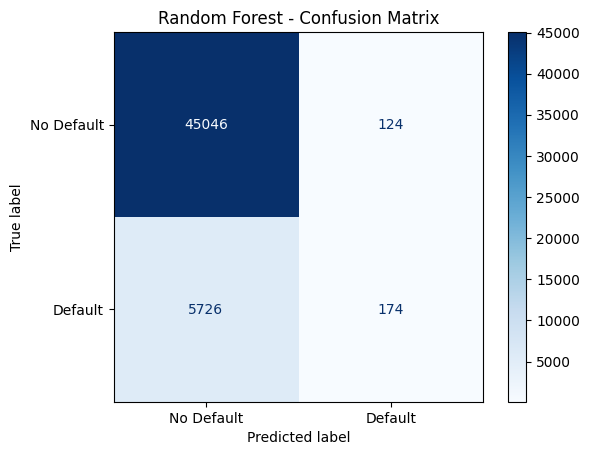

In [ ]:
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["No Default", "Default"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Random Forest - Confusion Matrix")
plt.show()

## That didnt work. What if we try to lower the threshold, which is currently 0.5?

In [ ]:
# Predict probabilities
y_probs = rf_model.predict_proba(X_val)[:, 1]

# Lower threshold to catch more defaulters
y_pred_low_thresh = (y_probs > 0.25).astype(int)
print(classification_report(y_val, y_pred_low_thresh))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92     45170
           1       0.37      0.26      0.30      5900

    accuracy                           0.86     51070
   macro avg       0.64      0.60      0.61     51070
weighted avg       0.84      0.86      0.85     51070



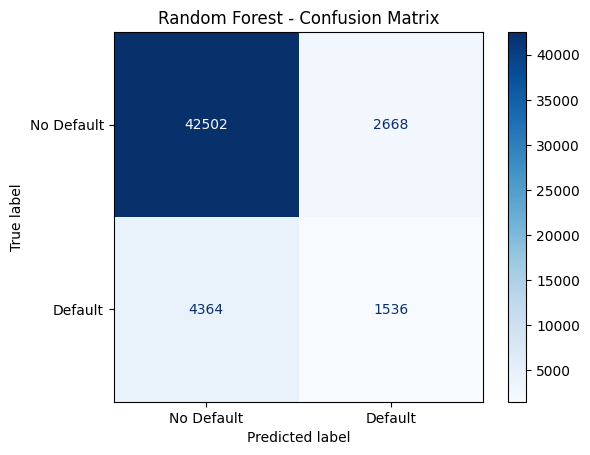

In [ ]:
cf_lt= confusion_matrix(y_val, y_pred_low_thresh)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_lt, display_labels=["No Default", "Default"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Random Forest - Confusion Matrix")
plt.show()

## Now the recall lates for defaulters are higher, and we are catching more defaulters. But surely there should be a better way.

## Lets try XGBoost, which is known to better handle imbalances

In [ ]:
from xgboost import XGBClassifier

# Calculate scale_pos_weight = (non-defaulters / defaulters)
ratio = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(scale_pos_weight=ratio,use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)


<Figure size 1000x600 with 0 Axes>

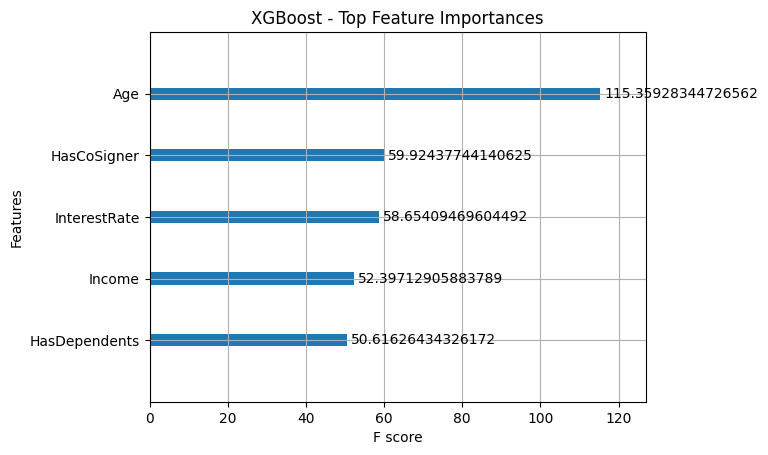

In [17]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot feature importances
plt.figure(figsize=(10, 6))
plot_importance(xgb, max_num_features=5, importance_type='gain')  # or 'weight', 'cover'
plt.title("XGBoost - Top Feature Importances")
plt.show()


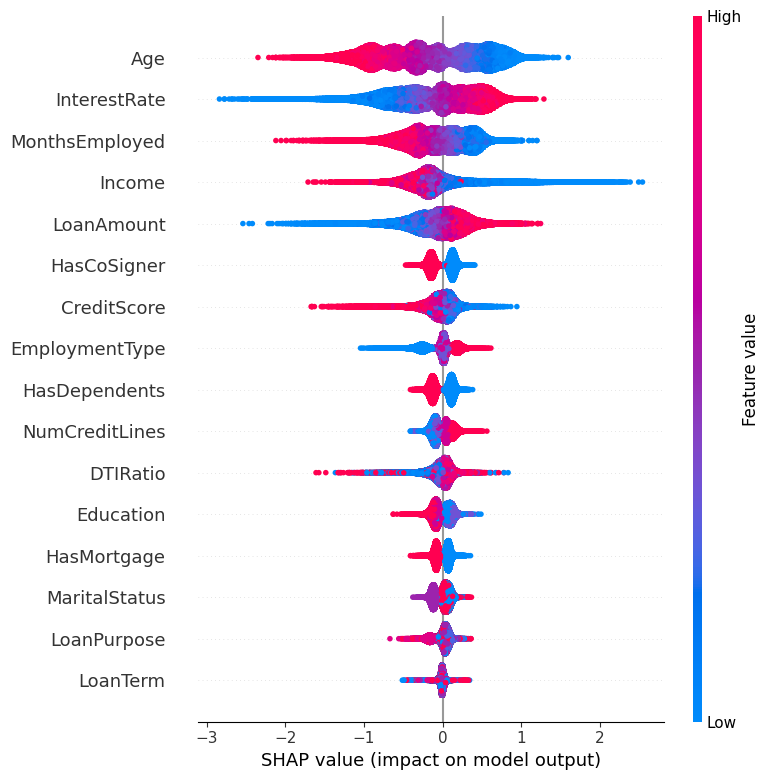

In [21]:
# 1. Install SHAP (if not already installed)
#!pip install shap

# 2. Import libraries
import shap
import matplotlib.pyplot as plt

# 3. Initialize SHAP
shap.initjs()

# 4. Create SHAP explainer for XGBoost
explainer = shap.TreeExplainer(xgb)

# 5. Compute SHAP values (sample if dataset is large)
# You can also use X_val directly if it's not too big
X_val_sample = X_train
shap_values = explainer.shap_values(X_val_sample)

# 6. Summary Plot: Feature importance + impact direction
shap.summary_plot(shap_values, X_val_sample)

# 7. Optional: Beeswarm (violin) plot for more detail
# shap.summary_plot(shap_values, X_val_sample, plot_type="violin")

# 8. Optional: Force plot for one prediction
# shap.force_plot(explainer.expected_value, shap_values[0], X_val_sample.iloc[0])


In [ ]:
y_predXGB=xgb.predict(X_val)
print(classification_report(y_val, y_predXGB))


              precision    recall  f1-score   support

           0       0.94      0.73      0.82     45170
           1       0.23      0.62      0.34      5900

    accuracy                           0.72     51070
   macro avg       0.58      0.67      0.58     51070
weighted avg       0.85      0.72      0.76     51070



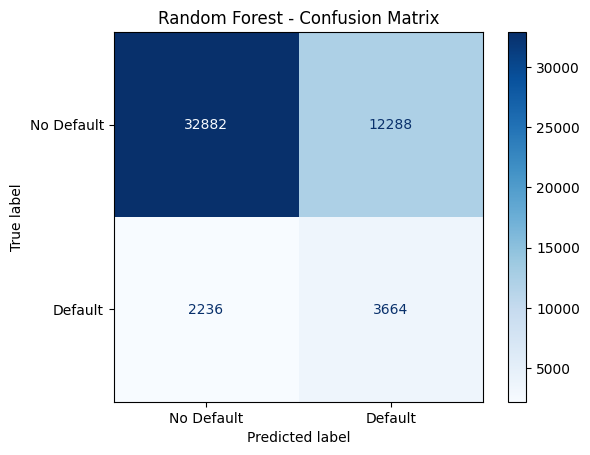

In [ ]:
cf_xgb= confusion_matrix(y_val, y_predXGB)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_xgb, display_labels=["No Default", "Default"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Random Forest - Confusion Matrix")
plt.show()

## We have succesfully increased the recall, but the number of false positives are way too high right now

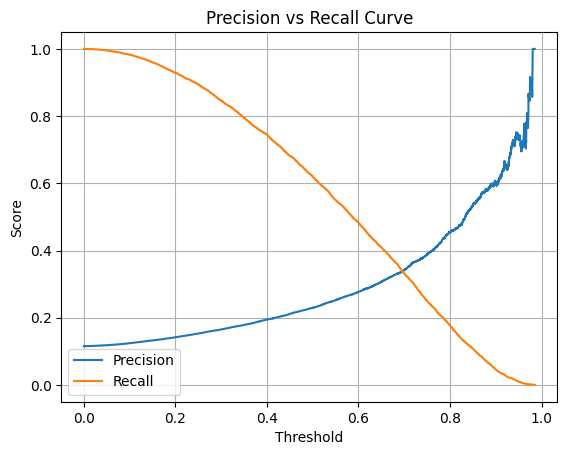

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve

# Predict probabilities
y_probs = xgb.predict_proba(X_val)[:, 1]

# Get precision-recall-threshold curve
precision, recall, thresholds = precision_recall_curve(y_val, y_probs)

# Plot to find a better threshold
import matplotlib.pyplot as plt
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision vs Recall Curve")
plt.legend()
plt.grid()
plt.show()


## This curve shows the trade off between Precision and Threshold. If our goal is to catch more risky borrowers we should pick a low threshold, and if we confidence in our borrowers and want to focus more on precision(for example, VIP clients), we should use a higher threshold. Now only 11 % of the total customers in this dataset are defaulters, so it makes sense to achieve a balance between precision and recall

In [ ]:
train_df['LoanAmount'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 255347 entries, 0 to 255346
Series name: LoanAmount
Non-Null Count   Dtype
--------------   -----
255347 non-null  int64
dtypes: int64(1)
memory usage: 1.9 MB


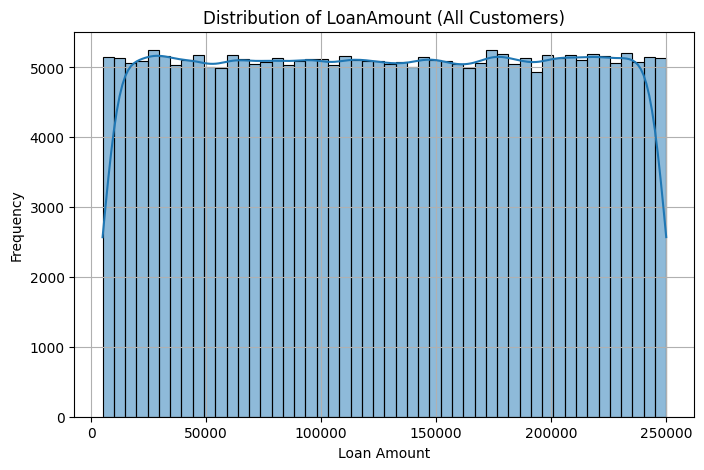

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(train_df['LoanAmount'], bins=50, kde=True)
plt.title("Distribution of LoanAmount (All Customers)")
plt.xlabel("Loan Amount")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

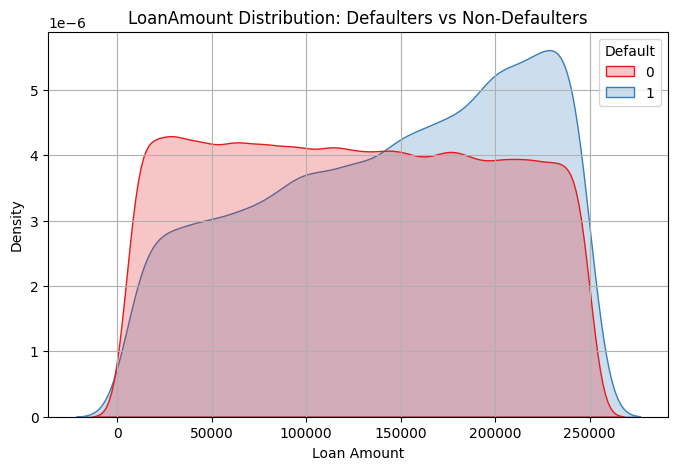

In [ ]:
plt.figure(figsize=(8, 5))
sns.kdeplot(data=train_df, x='LoanAmount', hue='Default', fill=True, common_norm=False, palette='Set1')
plt.title("LoanAmount Distribution: Defaulters vs Non-Defaulters")
plt.xlabel("Loan Amount")
plt.ylabel("Density")
plt.grid(True)
plt.show()


## This curve shows that there is a large number of defaulters with very large loan amounts. Therefore even though the no of defaulters is relatively small, their impact is huge. Therefore, for this problem we should prioritize increasing recall, and thus choose a lower threshold!

In [ ]:
# 1. Choose a lower threshold (e.g., 0.35)
threshold = 0.4

# 2. Make predictions using that threshold
y_pred_thresh = (y_probs > threshold).astype(int)

print(confusion_matrix(y_val, y_pred_thresh))

[[26988 18182]
 [ 1502  4398]]


## Unfortunately this dramatically increases the no of false positives - we are denying credit to 18k good customers - this will also lead to lost revenue. Ultimately the final decision depends on the business model and economic situation. For this case, I will choose to balance the recall and precision with a higher cutoff(it occurs at 0.7, see the precision recall curve)

In [ ]:
threshold = 0.7

# 2. Make predictions using that threshold
y_pred_thresh = (y_probs > threshold).astype(int)

print(confusion_matrix(y_val, y_pred_thresh))

[[41399  3771]
 [ 3940  1960]]


## The above result says that we caught 3940 defaulters with our model. But how much risk did we actually avoid? The answer depends on not only the number of caught defaulters, but on the loan amount. The traditional recall considers all defaulters as the same, but the dollar weighted recall converts this number to a more solid business risk measure

In [ ]:
total_default=X_val[y_val == 1]['LoanAmount'].sum()
total_default

In [ ]:
true_positives = (y_val == 1) & (y_pred_thresh == 1) 
captured_amount = X_val[true_positives]['LoanAmount'].sum()
captured_amount
dollar_recall = captured_amount / total_default


np.int64(713396797)

In [ ]:
dollar_recall

np.float64(0.8306042526716513)

## We correctly captured 83% of the total defaulted loan value with our model